In [33]:
import numpy as np
import matplotlib.pylab as plt
from scipy.ndimage import convolve1d
from scipy import signal as dsp

import filtering.filter_helper as utils

In [2]:
a = np.array([1,2,3])
b = np.array([4,5,6])  
np.dot(a,b)

32

# Signals

### sin wave with given frquency, sampling time

In [3]:
def create_sin_wave(f, duration, sampling_rate):

    omega = 2*np.pi*f #rad/s
    t = np.arange(0,duration,1/sampling_rate)
    sin_wave = np.sin(omega*t);

    return sin_wave, t

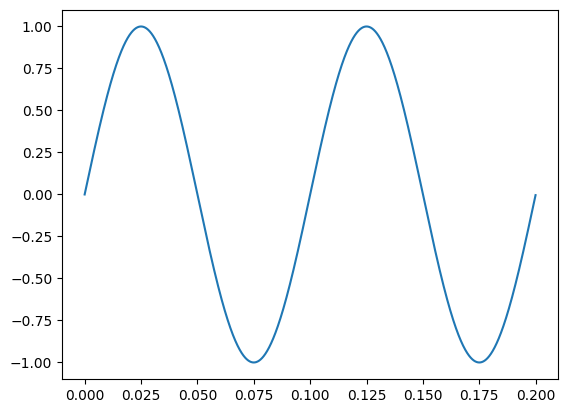

In [4]:
duration = 0.2 #s
sampling_rate = 16000 #Hz
f = 10 #hz
    
sin_wave, t = create_sin_wave(f, duration, sampling_rate)

plt.plot(t, sin_wave)

# step signal

In [5]:
def create_step_signal(step_time, step_amplitude, duration, sampling_rate):
    t = np.arange(-step_time,duration,1/sampling_rate)
    step_signal = np.heaviside(t, step_amplitude)
    
    # time-shift the signal
    t = t+step_time
    
    return step_signal,t

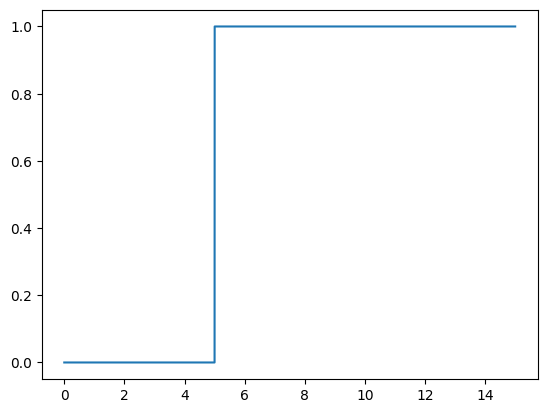

In [6]:
step_signal, t = create_step_signal(5, 1, 10, 16000)
plt.plot(t, step_signal)

# Filters

## Moving average filter

In [7]:
def apply_moving_avg_filter(noisy_signal, filter_size):

    ma_filter = np.ones(filter_size)
    
    filtered_signal = dsp.convolve(noisy_signal, ma_filter, mode='same') / np.sum(ma_filter)
    
    return filtered_signal

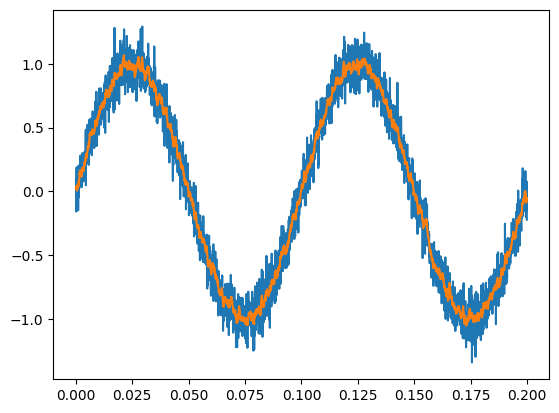

In [8]:
# create pure sine wave
sin_wave, t = create_sin_wave(f, duration, sampling_rate)

# create white noise signal
mean = 0
std_dev = 0.1
noise_signal =  np.random.normal(mean,std_dev,sin_wave.size)

# add noise to pure sin wave
noisy_sin_wave = sin_wave  + noise_signal
plt.plot(t, noisy_sin_wave)

ma_filter_size = 10

filtered_signal = apply_moving_avg_filter(noisy_sin_wave, ma_filter_size)

plt.plot(t, filtered_signal)
plt.show()

## Magnitude and phase response

##  Zero Phase filtering 

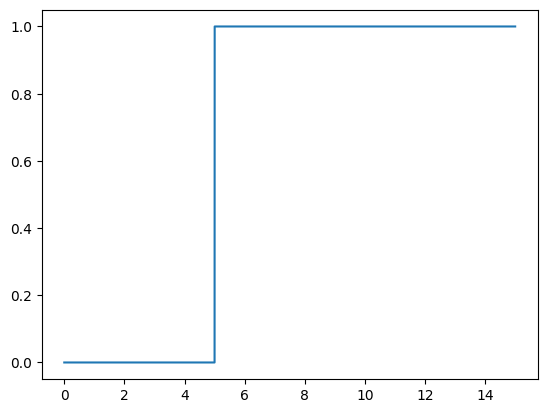

In [9]:
# create step input
step_signal, t = create_step_signal(5, 1, 10, 16000)
plt.plot(t, step_signal)

# apply zerp phase filter


## Low-pass filter (Continuous time)

In [54]:
import importlib


In [357]:
def filter_plotter(w_hz, mag_db, cutoff_freq_hz, amplitude_unit='dB', freq_unit='Hz'):  
    '''
    Plots the frequency response of a filter 

    Parameters
    -----------

    w_hz: frequency vector in Hz
    mag_db: amplitude vector in dB
    cutoff_freq_hz: cutoff frequency in Hz
    amplitude_unit: unit for plotting amplitude (normal or dB)
    freq_unit: unit for plotting frequency (Hz or rad/s)
    
    Returns
    ---------
    '''
    
    fig = plt.figure(figsize=(8, 3))

    # frequency axis
    freq_vec = None
    
    if freq_unit=='Hz':
        freq_vec = w_hz
        cutoff_freq = cutoff_freq_hz
        plt.xlabel("Frequency (Hz)")

    elif freq_unit=='rad_per_sec':
        freq_vec = hz_to_rad_per_sec(w_hz)
        cutoff_freq = hz_to_rad_per_sec(cutoff_freq_hz)
        plt.xlabel("Frequency (rad/sec)")

    else:
        raise Exception('Unknown frequency unit')
    
         
    #  Amplitude axis
    if amplitude_unit=='dB':
        mag = mag_db
        plt.semilogx(freq_vec, mag)    
        plt.ylabel("Amplitude (dB)")

    elif amplitude_unit=='normal':
        mag = 10.0 ** (mag_db/20)
        plt.semilogx(freq_vec, mag)    
        plt.ylabel("Amplitude (normal)")

    else:
        raise Exception('Unknown amplitude unit')
    
    # plot the cutoff frequency 
    plt.axvline(x = cutoff_freq, color = 'b', label = 'cutoff freq', linestyle=':')
    ax_list = fig.axes
    ax = ax_list[0]
    ax.text(cutoff_freq + 1 , +0.2, 'f_c', 
            fontsize = 10, color ="green", transform=ax.get_xaxis_transform())
    
    plt.grid()
    plt.show()

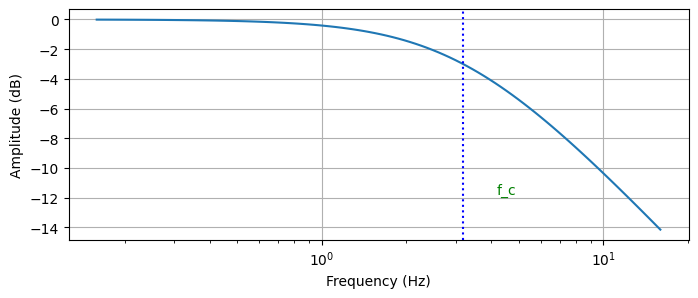

In [358]:
importlib.reload(utils)

f_c = 200 # cutoff frequency in Hz
omega_c = utils.hz_to_rad_per_sec(f_c)

omega_c = 20
f_c =  utils.rad_per_sec_to_hz(omega_c )

num = [omega_c]
den = [1,omega_c]

filter_sys = dsp.TransferFunction(num, den)

w_rad, mag, phase = filter_sys.bode() 
w_hz = utils.rad_per_sec_to_hz(w_rad)

filter_plotter(w_hz, mag, f_c, amplitude_unit='dB', freq_unit='Hz')

In [429]:
from enum import Enum

    
class Filter:

    class Mode(Enum):
        continuous = 1
        discrete = 2
    
    class Type(Enum):
        lowpass = 1
        highpass = 2
        bandpass = 3
        bandstop = 4
        notch = 5
        
    class Synthesis(Enum):
        simple_first_order = 1

    def __init__(self,mode=Mode.continuous, type = Type.lowpass, Synthesis= Synthesis.simple_first_order):
        self.Mode = mode
        self.Type = type
        self.Synthesis = Synthesis

        # time domain parameters
        self._rise_time = 0;
        self._overshoot = 0;
        self._rise_time = 0;

        # frequency domain parameters
        self._cutoff_freq_rad = 100;
        self._passband = 0
        self._stopband = 0

        self.filter = self.create_filter()

    def create_filter(self):
        match self.Type:
            case Filter.Type.lowpass:
                filter = self.create_lowpass_filter()
                print("creating lowpass filter")
                
            case Filter.Type.highpass:
                filter = self.create_highpass_filter()
                print("creating highpass filter")
                
            case _:
                raise Exception("Unknown filter type")

        return filter
                
    def create_lowpass_filter(self):
        omega_c = self._cutoff_freq_rad
        
        num = [omega_c]
        den = [1,omega_c]
        
        filter = dsp.TransferFunction(num, den)

        return filter

    def create_highpass_filter(self):
        omega_c = self._cutoff_freq_rad
        
        num = [omega_c, 0]
        den = [1,omega_c]
        
        filter = dsp.TransferFunction(num, den)

        return filter

    def magn_response(self):
        w_rad, mag, phase = self.filter.bode() 
        w_hz = utils.rad_per_sec_to_hz(w_rad)
        return w_hz, mag

    def plot_magn_response(self):
        w_hz, mag_db = self.magn_response()
        cutoff_freq_hz = self.get_cutoff_freq_hz()
        filter_plotter(w_hz, mag_db, cutoff_freq_hz , amplitude_unit='dB', freq_unit='Hz')

        
    # setter functions
    def set_cutoff_freq_rad_per_sec(self, val):
        self._cutoff_freq_rad = val
        self.filter = self.create_filter()
        
    def set_cutoff_freq_hz(self, val):
        cutoff_freq_rad = utils.hz_to_rad_per_sec(val)
        self.set_cutoff_freq_rad_per_sec(cutoff_freq_rad)
        
    # getter method
    def get_cutoff_freq_hz(self):
        cutoff_freq_hz = utils.rad_per_sec_to_hz(self._cutoff_freq_rad)
        return cutoff_freq_hz

    def get_cutoff_freq_rad(self):
        return self._cutoff_freq_rad

    def get_passband(self):
        return self._passband

    def get_stopband(self):
        return self._stopband

creating lowpass filter
creating lowpass filter


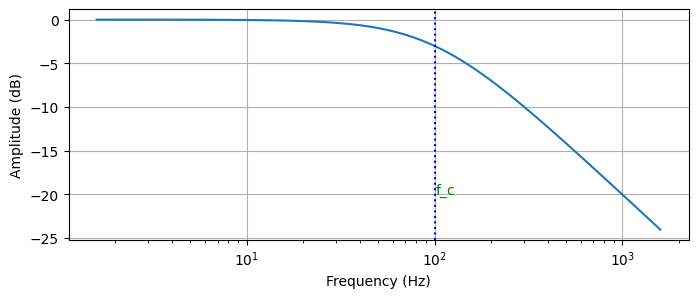

In [430]:
lowpass_filter = Filter(Filter.Type.lowpass)
lowpass_filter.set_cutoff_freq_hz(100)

lowpass_filter.plot_magn_response()

In [431]:
highpass_filter = Filter(type =Filter.Type.highpass)
highpass_filter.set_cutoff_freq_hz(100)

highpass_filter.plot_magn_response()

Exception: Unknown filter type